# Assignment 2: Classification Analysis

## Dataset: Phishing Websites Dataset

**Selected Dataset**: UCI Phishing Websites Dataset (ID: 327)

**Classification Task**: Binary classification to detect phishing websites vs legitimate websites


In [17]:
def brute_froce_LOO(X_train, y_train, X_test, y_test, idx_list, ap_baseline):

    print("Brute Force LOO Running...")

    records = []
    for i in idx_list:
        mask = np.ones(X_train.shape[0], dtype=bool)
        mask[i] = False
        X_tr, y_tr = X_train[mask], y_train[mask]

        rf = RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        proba = rf.predict_proba(X_test)[:, 1]
        ap_loo = average_precision_score(y_test, proba)
        impact = ap_baseline - ap_loo

        records.append({"train_idx": i, "AP_full": ap_baseline, "AP_LOO": ap_loo, "Impact": impact})
        print(f"Removed train idx {i} | AP_LOO={ap_loo:.4f} | Impact={impact:+.4f}")

    df = pd.DataFrame(records).sort_values(by="Impact", ascending=False).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(df)), df["Impact"])
    plt.xticks(range(len(df)), df["train_idx"].astype(str), rotation=45, ha="right")
    plt.ylabel("Impact (AP_full - AP_LOO)")
    plt.title("LOO Impact on AP using RandomForest")
    plt.tight_layout()
    plt.show()

    print("\nBrute Force LOO Result")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return df

In [18]:
def confusion_matrix_plot(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation="nearest", cmap="Blues")

    ticks = np.arange(len(labels))
    ax.set_xticks(ticks); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks(ticks); ax.set_yticklabels(labels)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    fig.tight_layout()
    plt.show()

In [19]:
def pr_curve_binary(y_true, proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, lw=2, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return ap

In [20]:
def roc_curve_binary(y_true, proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc


In [21]:
def train_eval(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")

    print(f"\n{model_name} is trained and evaluated")
    print(f"Accuracy: {acc:.4f} | F1(macro): {f1m:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Legit", "Phishing"], digits=4))

    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    ap = average_precision_score(y_test, proba) if proba is not None else np.nan
    rocauc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    print(f"AP(PR-AUC): {ap:.4f} | ROC-AUC: {rocauc:.4f}")

    return (model_name, y_pred, proba, acc, f1m, ap, rocauc)

## 1. Import Libraries and Load Dataset (2 marks)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 1.1 Load Dataset
Loading the Phishing Websites dataset from UCI repository.

In [23]:

phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features.values
y = phishing_websites.data.targets.values.ravel()
y = np.where(y == -1, 0, 1)
labels = ["Legit", "Phishing"]

## 2. Process Features and Labels (2 marks)
The dataset contains 30 numerical features extracted from website URLs and HTML content.
All features are already numerical, so we only need standardization.
## 3.Train/Test Split (2 marks)
**Split strategy**: 75/25 stratified random split
- Training set: 75% of data
- Test set: 25% of data
- Random state: 42 for reproducibility

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


## 4. Train Classifiers (2 marks)

**Selected models**:
1. **K-Nearest Neighbors (KNN)**
2. **Logistic Regression**
3. **Support Vector Machine (SVC)**
4. **Random Forest**

In [25]:

models = [
    ("KNN", KNeighborsClassifier(n_neighbors=15)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=7, class_weight="balanced")),
    ("SVC", SVC(kernel="rbf", probability=True, random_state=7, class_weight="balanced")),
    ("Random Forest", RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)),
]

results = []
for name, model in models:
    results.append(train_eval(name, model, X_train_scaled, X_test_scaled, y_train, y_test))


KNN is trained and evaluated
Accuracy: 0.9392 | F1(macro): 0.9385
              precision    recall  f1-score   support

       Legit     0.9286    0.9347    0.9317      1225
    Phishing     0.9477    0.9428    0.9453      1539

    accuracy                         0.9392      2764
   macro avg     0.9382    0.9388    0.9385      2764
weighted avg     0.9393    0.9392    0.9392      2764

AP(PR-AUC): 0.9849 | ROC-AUC: 0.9849

Logistic Regression is trained and evaluated
Accuracy: 0.9287 | F1(macro): 0.9278
              precision    recall  f1-score   support

       Legit     0.9186    0.9208    0.9197      1225
    Phishing     0.9368    0.9350    0.9359      1539

    accuracy                         0.9287      2764
   macro avg     0.9277    0.9279    0.9278      2764
weighted avg     0.9287    0.9287    0.9287      2764

AP(PR-AUC): 0.9851 | ROC-AUC: 0.9815

SVC is trained and evaluated
Accuracy: 0.9541 | F1(macro): 0.9533
              precision    recall  f1-score   support



## 5. Performance Evaluation

### Primary Metric: Average Precision (AP) (2 marks)
**Choice**: Average Precision (area under precision-recall curve)

In [26]:

best = max(results, key=lambda t: t[5])
print(f"Best by AP: {best[0]} | AP={best[5]:.4f}")
best_model_name, best_pred, best_proba, best_acc, best_f1m, best_ap, best_rocauc = best
print(f"\nBest model by AP: {best_model_name} | AP={best_ap:.4f} | F1m={best_f1m:.4f} | Acc={best_acc:.4f}")

Best by AP: Random Forest | AP=0.9983

Best model by AP: Random Forest | AP=0.9983 | F1m=0.9743 | Acc=0.9747


### Confusion Matrix

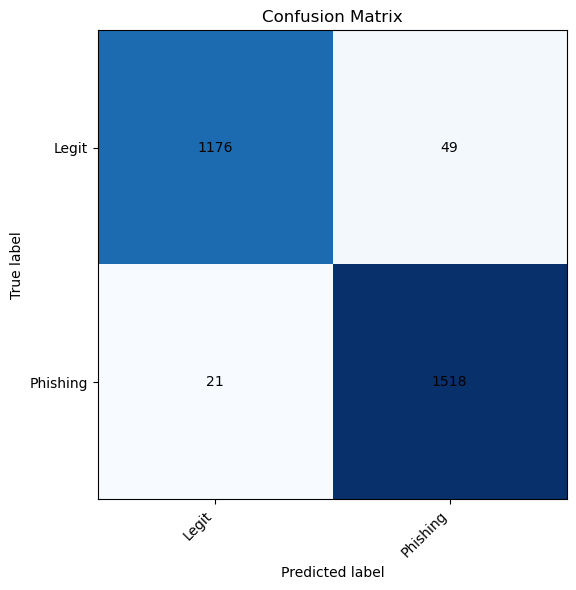

In [27]:
confusion_matrix_plot(y_test, best_pred, labels)

### Precision-Recall Curve

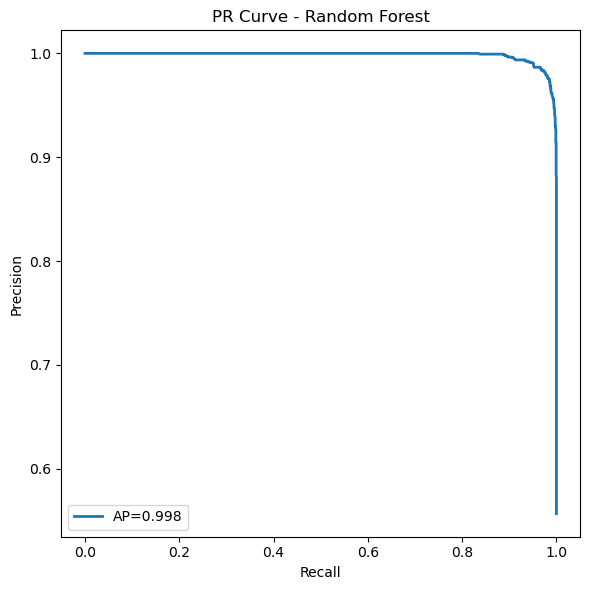

0.998286347905662

In [28]:
pr_curve_binary(y_test, best_proba, title=f"PR Curve - {best_model_name}")

### ROC Curve

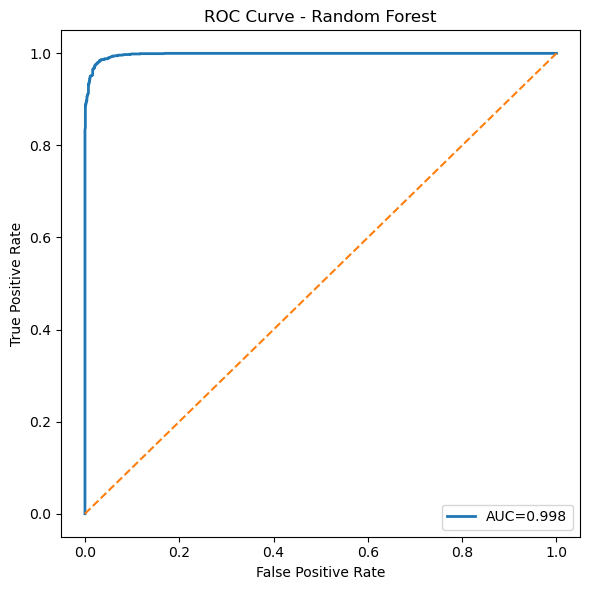

0.9978509766479692

In [29]:
roc_curve_binary(y_test, best_proba, title=f"ROC Curve - {best_model_name}")

## Part 2: Brute Force LOO Influence (8 marks)

Brute Force LOO Running...
Removed train idx 0 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 799 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 1599 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 2399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 3199 | AP_LOO=0.9982 | Impact=+0.0000
Removed train idx 3999 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 4799 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 5599 | AP_LOO=0.9983 | Impact=+0.0000
Removed train idx 6399 | AP_LOO=0.9983 | Impact=-0.0000
Removed train idx 7199 | AP_LOO=0.9983 | Impact=+0.0000


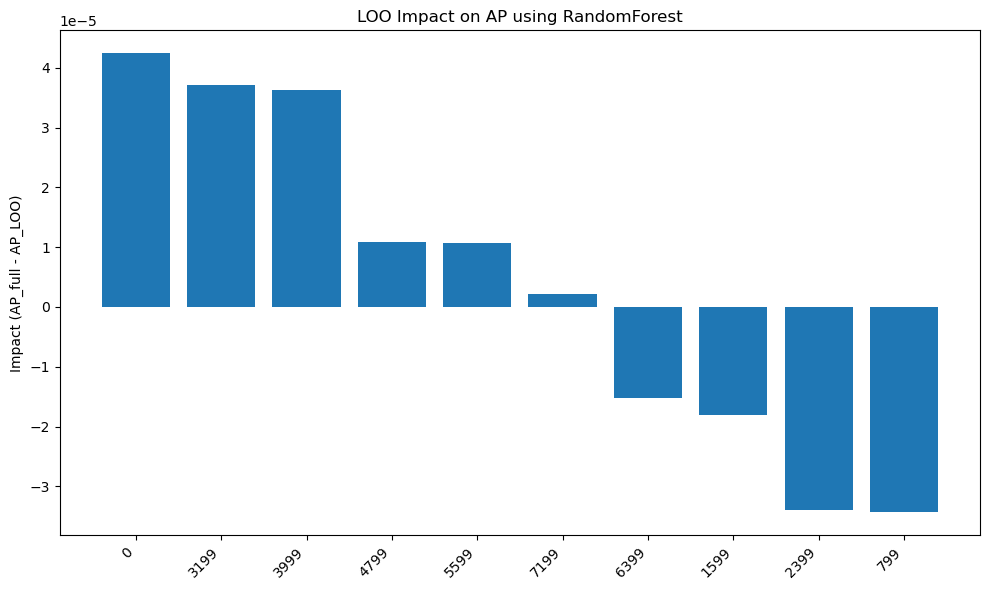


Brute Force LOO Result
 train_idx  AP_full  AP_LOO  Impact
         0   0.9983  0.9982  0.0000
      3199   0.9983  0.9982  0.0000
      3999   0.9983  0.9983  0.0000
      4799   0.9983  0.9983  0.0000
      5599   0.9983  0.9983  0.0000
      7199   0.9983  0.9983  0.0000
      6399   0.9983  0.9983 -0.0000
      1599   0.9983  0.9983 -0.0000
      2399   0.9983  0.9983 -0.0000
       799   0.9983  0.9983 -0.0000


,train_idx,AP_full,AP_LOO,Impact
0,0,0.998286,0.998244,0.000042
1,3199,0.998286,0.998249,0.000037
2,3999,0.998286,0.998250,0.000036
3,4799,0.998286,0.998275,0.000011
4,5599,0.998286,0.998276,0.000011
5,7199,0.998286,0.998284,0.000002
6,6399,0.998286,0.998302,-0.000015
7,1599,0.998286,0.998304,-0.000018
8,2399,0.998286,0.998320,-0.000034
9,799,0.998286,0.998321,-0.000034


In [30]:
idx_list = [0, 799, 1599, 2399, 3199, 3999, 4799, 5599, 6399, 7199]
brute_froce_LOO(X_train_scaled, y_train, X_test_scaled, y_test, idx_list, best_ap)

## Part 3: Group-level influence (8 marks)

In [49]:
def group_leave_out(X_train, y_train, X_test, y_test, group_sizes, ap_baseline):
    records = []
    np.random.seed(42)
    for group_size in group_sizes:
        n_samples = int(len(X_train) * group_size / 100)

        remove_indices = np.random.choice(len(X_train), n_samples, replace=False)
        keep_mask = np.ones(len(X_train), dtype=bool)
        keep_mask[remove_indices] = False

        # Train model without this group
        X_tr, y_tr = X_train[keep_mask], y_train[keep_mask]

        rf = RandomForestClassifier(n_estimators=300, random_state=7, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        proba = rf.predict_proba(X_test)[:, 1]
        ap_without = average_precision_score(y_test, proba)
        influence = ap_baseline - ap_without

        records.append({
            "group_size_pct": group_size,
            "group_size_n": n_samples,
            "AP_full": ap_baseline,
            "AP_without": ap_without,
            "influence": influence
        })
        print(f"Group size {group_size}% ({n_samples} samples) | AP={ap_without:.4f} | Influence={influence:+.4f}")

    df = pd.DataFrame(records)

    plt.figure(figsize=(10, 6))
    plt.plot(df["group_size_pct"], df["influence"], marker='o', linewidth=2, markersize=8)
    plt.xlabel("Group Size (%)", fontsize=12)
    plt.ylabel("Influence (AP_full - AP_without)", fontsize=12)
    plt.title("Group-Level Influence: Impact of Removing Training Data Groups", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df["group_size_n"], df["influence"], marker='o', linewidth=2, markersize=8, color='orange')
    plt.xlabel("Group Size (Number of Samples)", fontsize=12)
    plt.ylabel("Influence (AP_full - AP_without)", fontsize=12)
    plt.title("Group-Level Influence vs Absolute Group Size", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




Group size 5% (414 samples) | AP=0.9981 | Influence=+0.0002
Group size 10% (829 samples) | AP=0.9981 | Influence=+0.0001
Group size 15% (1243 samples) | AP=0.9976 | Influence=+0.0007
Group size 20% (1658 samples) | AP=0.9973 | Influence=+0.0010
Group size 30% (2487 samples) | AP=0.9968 | Influence=+0.0015
Group size 40% (3316 samples) | AP=0.9941 | Influence=+0.0042
Group size 50% (4145 samples) | AP=0.9961 | Influence=+0.0022
Group size 60% (4974 samples) | AP=0.9952 | Influence=+0.0031
Group size 70% (5803 samples) | AP=0.9942 | Influence=+0.0041
Group size 80% (6632 samples) | AP=0.9920 | Influence=+0.0063


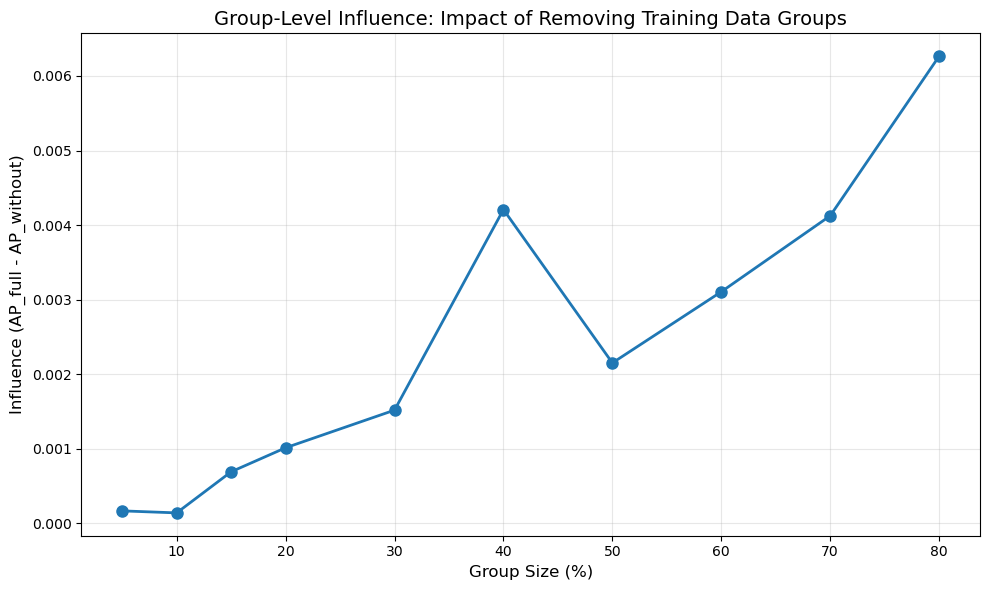

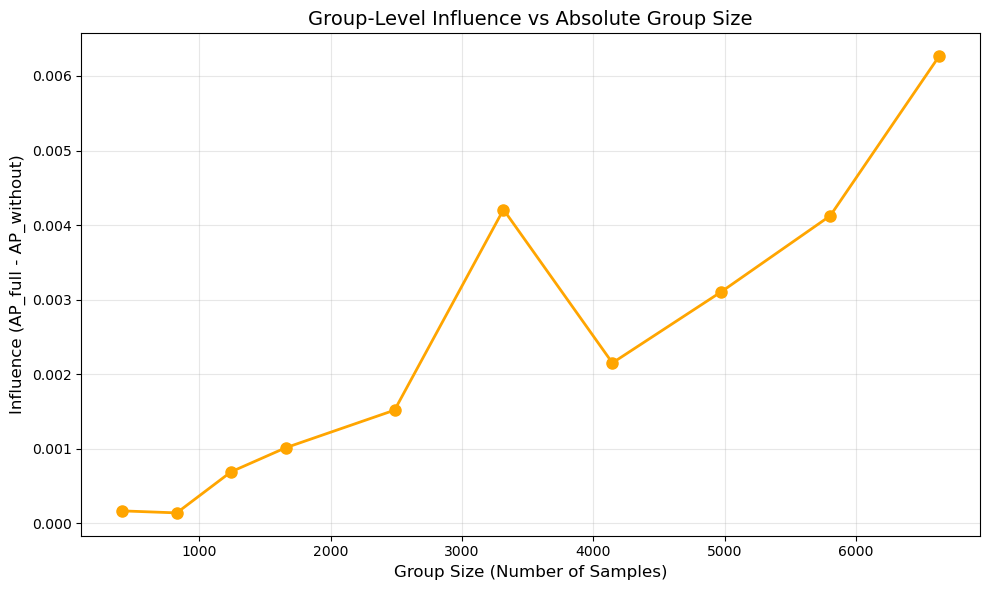

In [52]:
group_sizes = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]

# Run group-level analysis
group_results = group_leave_out(
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    group_sizes,
    best_ap
)